In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from multiprocessing import Pool
sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/Module_Analysis/')
import Pair_Corelation_Function as PCF
#import Clustering as Clust
sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/Gillespie_backend')
import Gillespie_backend as backend
import Simulate_System as SimSys
sys.path.append('/home/hcleroy/Extra_Module_py/')
import formated_matplotlib

In [2]:
# define the unit of the system :
dimension = 3

L = 1000
NLinker = 10

Eb = -10.

kdiff = 0.000207352*5

seed = np.random.randint(0,1000000)

In [127]:
def Norm(x_array,y_array):
    """"
    a function is represented by a y_array and a x_array. this function return the norm 2
    """
    if y_array.__len__() != x_array.__len__():
        raise ValueError
    return np.sqrt(np.sum(np.array([((x_array[i+1]-x_array[i])*y_array[i])**2 for i in range(x_array.__len__()-1)])))
def Concatenate_dists(Syss):
    """
    This function takes a list of replicas, and return a single array with all the distances between linkers
    """
    dists = np.zeros((Syss.__len__(),Syss[0].Nlinker*(Syss[0].Nlinker-1)//2),dtype=float)
    # first compute the distance between linkers for each replica:
    for n in range(Syss.__len__()):
        k=0
        for i in range(Syss[n].Nlinker):
            for j in range(0,i):
                dists[n,k] = np.linalg.norm(Syss[n].get_r()[i]-Syss[n].get_r()[j])
                k+=1
    #return a concatenate version of all the distances.
    return np.concatenate(dists,axis=0)
#np.concatenate(np.array([Rs_replica[j][i*dt:(i+1)*dt] for j in range(Nreplica)]),axis=0)
def twobody_dist_prob_from_dist(D,bins=100):
    """
    This function takes a list of distance, and compute the probability associated which each distance.
    It accounts for the fact that the linkers are in a 3d. Thus the probability of being at a distance
    D has to be corrected by the volume of the shell.
    """
    maxD = np.max(D)
    ddist = maxD/(bins-1)
    def I(dist):
        return int(dist/ddist)
    def v_shell(dist):
        return 4/3*np.pi*((dist+ddist)**3 - dist**3)
    X = np.linspace(0,maxD,bins)
    PR = np.zeros(bins,dtype=float)
    for d in D:
        if d!=0:
            try:
                PR[I(d)] += 1/v_shell(d)*1/(D.shape[0])
            except IndexError:
                pass
    return X,PR

def Time_to_reach_equilibrium(ell_tot,rho0,BindingEnergy,kdiff,seed,Nlinker,dimension,compute_step,epsilon,Nreplica):
    """
    This function create a system, and make it evolve. It computes the pair correlation function on the fly every compute_step.
    Whenever the norm of the difference of two succesives pair correlation functions is smaller than epsilon : stop the simulation and
    return the time.

    We have the possibility to use several replica in parallel to compute the pair correlation function. This is especially important
    whenever there are very few linkers, or whenever the system is supposed to evolve quickly.
    """
    np.random.seed(seed)
    # make an array of Gillespie simulations:
    Syss = [backend.Gillespie(  ell_tot=ell_tot,
                                rho0=rho0,
                                BindingEnergy=BindingEnergy,
                                kdiff=kdiff,
                                seed = s,
                                Nlinker=Nlinker,
                                dimension=dimension) for s in np.random.randint(0,100000,Nreplica)]
    # initialize the two probability distributions:
    D = Concatenate_dists(Syss)
    X,g1 = twobody_dist_prob_from_dist(D,bins=100)
    g2 = np.zeros(100,dtype=float)
    # setup a counter to avoid infinit loop
    counter=0
    # t is the time of the simulation:
    t=0
    # the simulation keeps going until the system is equilibrated
    while Norm(X,g1-g2)/Norm(X,g1+g2)>epsilon and counter < 100:
        # Dists in the concatenation of all the distances between linkers of all the replica for each steps in compute_step.
        Dists = []
        # make a serie of step between each computation of the two body distrib
        for i in range(compute_step):
            # time is used to compute the average time of all moves
            time = []
            for Sys in Syss:
                movetype,Dt = Sys.evolve()
                time.append(np.sum(Dt))
            # add up the average time of the moves to the total time
            t += np.mean(time)
            # extend the Dists array with the concatenation of the distances between linkers of all replicas
            Dists.extend(Concatenate_dists(Syss))
        Dists=np.array(Dists)
        # keep track of the previous g
        g2 = g1
        # actualize the new g
        X,g1 = twobody_dist_prob_from_dist(Dists,bins=100)
        print(Norm(X,g1-g2)/Norm(X,g1+g2))
        counter+=1   
    plt.plot(X,g1)
    plt.plot(X,g2)
    return t

0.48766108712148276
0.06555631473751222


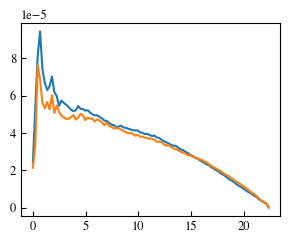

In [128]:
time_1 = Time_to_reach_equilibrium(  ell_tot=L,
                            rho0=0.,
                            BindingEnergy=Eb,
                            kdiff=kdiff,
                            seed = seed,
                            Nlinker=2,
                            dimension=dimension,
                            compute_step=1000,
                            epsilon=0.1,
                            Nreplica=1000)

In [129]:
time_1

2684134.6667763805

0.834210314213744
0.4817589312663932
0.11640088920051639
0.06414503306017516


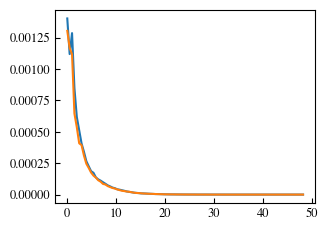

In [130]:
time_10 = Time_to_reach_equilibrium(  ell_tot=L,
                            rho0=0.,
                            BindingEnergy=Eb,
                            kdiff=kdiff,
                            seed = seed,
                            Nlinker=10,
                            dimension=dimension,
                            compute_step=1000,
                            epsilon=0.1,
                            Nreplica=100)

In [131]:
time_10

2458377.6755077415